In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install soundfile

In [0]:
import os
import glob
import numpy as np
import pandas as pd
import random
import soundfile as sf
import matplotlib.pyplot as plt
import librosa

import sys
sys.path.append('/content/drive/My Drive/DCASE19 ASC/')
import tfutil

In [0]:
# Check if all binary files are created
os.chdir('/content/drive/My Drive/DCASE19 ASC/')
os.listdir()
audiopath = './MelSpectrogram/PSDdB/'

txt = audiopath + 'airport*'
airportaddrs = glob.glob(txt)
txt = audiopath + 'shopping_mall*'
shopping_malladdrs = glob.glob(txt)
txt = audiopath + 'metro_station*'
metro_stationaddrs = glob.glob(txt)
txt = audiopath + 'street_pedestrian*'
street_pedestrianaddrs = glob.glob(txt)
txt = audiopath + 'public_square*'
public_squareaddrs = glob.glob(txt)
txt = audiopath + 'street_traffic*'
street_trafficaddrs = glob.glob(txt)
txt = audiopath + 'tram*'
tramaddrs = glob.glob(txt)
txt = audiopath + 'bus*'
busaddrs = glob.glob(txt)
txt = audiopath + 'metro-*'
metroaddrs = glob.glob(txt)
txt = audiopath + 'park*'
parkaddrs = glob.glob(txt)


npyaddrs = [airportaddrs, shopping_malladdrs, metro_stationaddrs,
         street_pedestrianaddrs, public_squareaddrs, street_trafficaddrs,
         tramaddrs, busaddrs, metroaddrs, parkaddrs]

npyaddrs = np.asarray(npyaddrs)
print(npyaddrs.shape)


In [0]:
# Reading all the available filename for each recording type and display the number of recordings
# IMPORTANT: You might need to execute this section again, if the next part does not work correctly.
os.chdir('/content/drive/My Drive/DCASE19 ASC/')
os.listdir()
audiopath = './TAU-urban-acoustic-scenes-2019-development/audio/'

txt = audiopath + 'airport*.wav'
airportaddrs = glob.glob(txt)
txt = audiopath + 'shopping_mall*.wav'
shopping_malladdrs = glob.glob(txt)
txt = audiopath + 'metro_station*.wav'
metro_stationaddrs = glob.glob(txt)
txt = audiopath + 'street_pedestrian*.wav'
street_pedestrianaddrs = glob.glob(txt)
txt = audiopath + 'public_square*.wav'
public_squareaddrs = glob.glob(txt)
txt = audiopath + 'street_traffic*.wav'
street_trafficaddrs = glob.glob(txt)
txt = audiopath + 'tram*.wav'
tramaddrs = glob.glob(txt)
txt = audiopath + 'bus*.wav'
busaddrs = glob.glob(txt)
txt = audiopath + 'metro-*.wav'
metroaddrs = glob.glob(txt)
txt = audiopath + 'park*.wav'
parkaddrs = glob.glob(txt)


addrs = [airportaddrs, shopping_malladdrs, metro_stationaddrs,
         street_pedestrianaddrs, public_squareaddrs, street_trafficaddrs,
         tramaddrs, busaddrs, metroaddrs, parkaddrs]

addrs = np.asarray(addrs)

In [0]:
print(addrs.shape)
print(addrs[0][100])
print(np.size(addrs[0]))

(10, 1440)
./MelSpectrogram/PSDdB/airport-stockholm-207-6309-a.npy
1440


In [0]:
# Helper function to plot the Power Spectral Density
def plot_images(psd, addr, plotrows, figSizeHeight=10):
  
  #nrow, ncol = psd[0].shape
  #plotrows = int(np.floor(nrow/2))

  figSizeWidth = 20
  #figSizeHeight = 20

  # Create figure with sub-plots.
  fig, axes = plt.subplots(5, 4)
  fig.set_size_inches(figSizeWidth, figSizeHeight)

  # Adjust spacing between subplots.
  hspace = 1
  fig.subplots_adjust(hspace=hspace, wspace=0.3)


  for i, ax in enumerate(axes.flat):
      # There may be less than 10 images, ensure it doesn't crash.
      if i < len(addr):
          # Plot image.
          image = psd[i]
          #maxpsd = np.max(image[0][0:nrow])   # The display is set to range [0:maxpsd], where maxpsd=3.1813424. Anything larger than that will have full pixel value of 255
          ax.imshow(image[0:plotrows],
                    cmap='gray_r', 
                    vmin=0, 
                    vmax=255, 
                    origin='lower')

          # Show true and predicted classes.
          xlabel = os.path.basename(addr[i])

          # Show the classes as the label on the x-axis.
          ax.set_xlabel(xlabel)

      # Remove ticks from the plot.
      ax.set_xticks([])
      ax.set_yticks([])

  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell.
  plt.show()

  np.size(image)

In [0]:
sound,fs = sf.read(addrs[0,1])

# Creating Mel filters
frange = fs/2   #Frequency range
n_mels = 128     #Number of mel filters


# Define Mel Spec parameters
framesize = 0.04 #Setting frame size to 2 msec
n_fft=int(np.floor(framesize*fs))
overlap = 2
hop_length = int(n_fft/overlap)
win_length = n_fft
center = True
stft_config = dict(n_fft=n_fft, 
                   hop_length=hop_length, 
                   win_length=n_fft, 
                   window='hamming')
lenSound = int(np.floor(len(sound)/fs)*fs)
fDim = int(np.floor(n_fft/2) + 1)
tDim = int(lenSound/(fDim-1))+ 1

# Define the MFCC filter bank
melfb = np.asarray(librosa.filters.mel(frange, n_fft, n_mels))


# Creating Mel Spectrogram
def createMelSpec(sound, melfb):
  STFT = librosa.stft(sound, **stft_config)  
  
  mag = np.asarray(np.abs(STFT))
  tmppsd = np.multiply(mag,mag)
  
  melspec = melfb.dot(tmppsd)
  
  return melspec


128 501


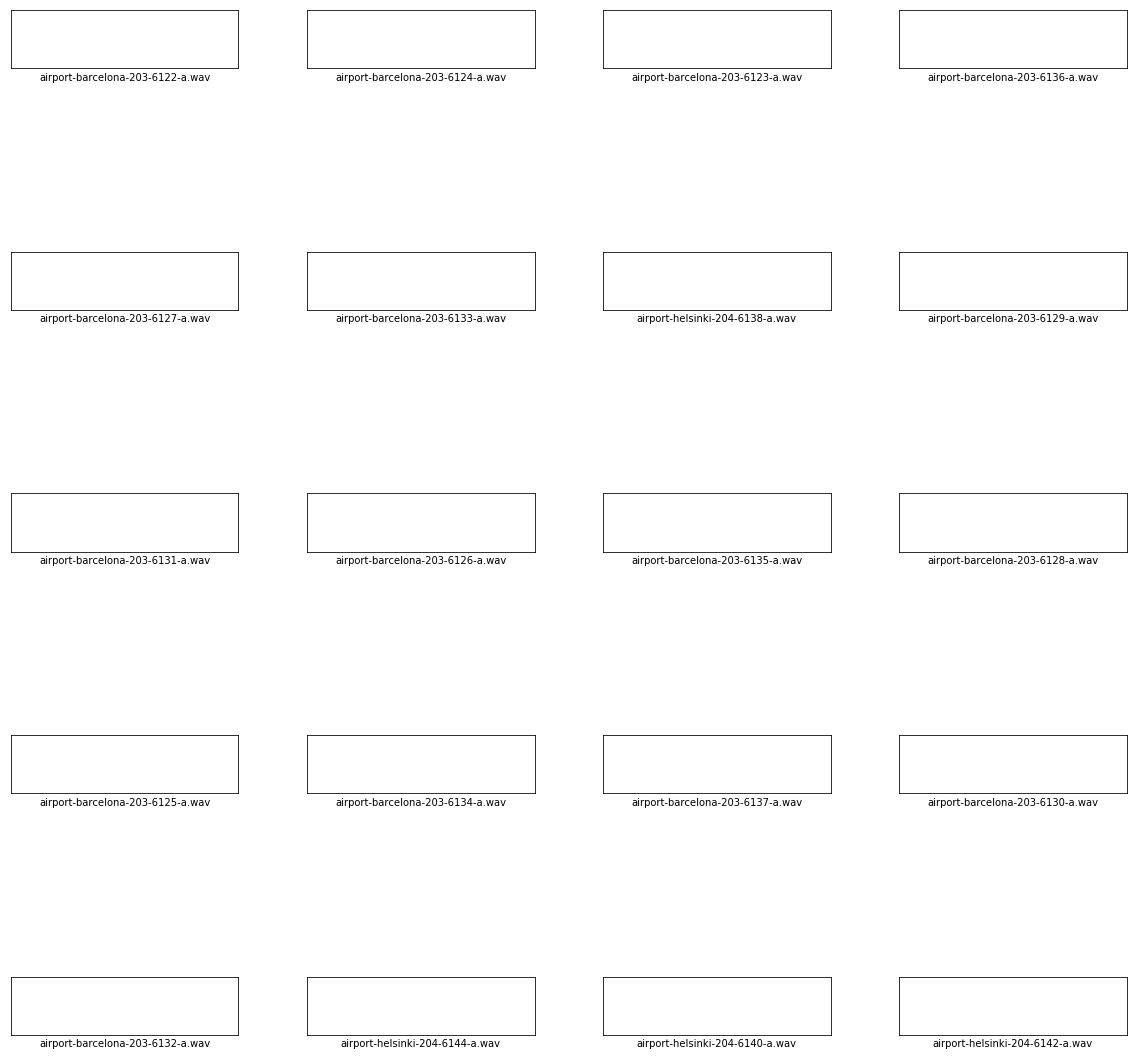

In [0]:
melspec = [[] for x in range(30)]
recordtype = 0

for i in range(1):
  for j in range(30):
    addr = addrs[recordtype][j]
    audio, fs = sf.read(addr)
    sound1 = audio[:,0]
    melspec[j] = createMelSpec(sound1, melfb)

melspec = np.array(melspec)
nrow,ncol = melspec[0].shape
print(nrow,ncol)
plot_images(melspec[0:20],addrs[recordtype][0:20], nrow, 20)




In [0]:
del(melspec)

In [0]:
# create and save the squeezed PSD with double emphasis into binary file
OutPathNormalPSD = '/content/drive/My Drive/DCASE19 ASC/MelSpectrogram/NormalPSD/'
OutPathPSDdB = '/content/drive/My Drive/DCASE19 ASC/MelSpectrogram/PSDdB/'


recordtype = ['airport','shopping_mall','metro_station','street_pedestrian',
             'public_square', 'street_traffic', 'tram', 'bus', 'metro', 'park']


for i in range(3):
  numfiles = np.size(addrs[i+7])
  print('\n \n')
  print('processing ', recordtype[i+7])
  for j in range(numfiles):
    addr = addrs[i+7][j]
    
    # Processing signal
    audio, fs = sf.read(addr)
    sound1 = audio[:,0]
    
    melspec = createMelSpec(sound1, melfb)
    melspec = np.array(melspec)
    
    melspecdB = 10*np.log10(melspec)

    
    # Saving data to file
    filename, _ = os.path.splitext(os.path.basename(addr))
    
    filenameNormal = OutPathNormalPSD+filename+'.npy'
    print('Filename: ',i+7, ',  ',j, ' ',  filenameNormal)
    #freqSqueezedPSD.to_csv(filename, sep=',', header=False, index=False) # Not using pd.DataFrame
    np.save(filenameNormal, melspec)
    
    filenamedB = OutPathPSDdB+filename+'.npy'
    print('Filename: ',i+7, ',  ',j, ' ',  filenamedB)
    #freqSqueezedPSD.to_csv(filename, sep=',', header=False, index=False) # Not using pd.DataFrame
    np.save(filenamedB, melspecdB)
    
    
    

